## PyTorch Workflow

1. Obtendo dados
2. Construção do modelo
3. Fitting
4. Predições e evaluações
5. Salvando e carregando o modelo
6. Juntando tudo

In [19]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

### Obtendo dados

Machine learning é um jogo de duas partes:

1. Obter uma representação numérica para os dados; e
2. Construir um modelo que encontra padrões na representação numérica.

Para demonstrar isso, iremos criar um conjunto de dados _conhecido_ utilizando uma fórmula.

Vamos construir uma linha reta com parâmetros conhecidos.

In [6]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
Y = weight * X + bias # y = ax + b

In [13]:
print(X[:5], len(X))
print(Y[:5], len(Y))

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]]) 50
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]]) 50


Separando em datasets de treinamento e teste:

In [14]:
training_split = 40

X_TRAIN, Y_TRAIN = X[:training_split], Y[:training_split]
X_TEST, Y_TEST = X[training_split:], Y[training_split:]

print(len(X_TRAIN), len(X_TEST))
print(len(Y_TRAIN), len(Y_TEST))

40 10
40 10


In [17]:
def plot(train_data=X_TRAIN, train_labels=Y_TRAIN, test_data=X_TEST, test_labels=Y_TEST, predictions=None):
    plt.figure(figsize=(10, 7))

    # Dados de treinamento em azul:
    plt.scatter(train_data, train_labels, c='blue', s=4, label='Training data')

    # Dados de teste em vermelho:
    plt.scatter(test_data, test_labels, c='red', s=4, label='Testing data')

    if predictions is not None:
        plt.scatter(test_data, predictions, c='green', label='Predictions')

    plt.legend(prop={'size': 14})

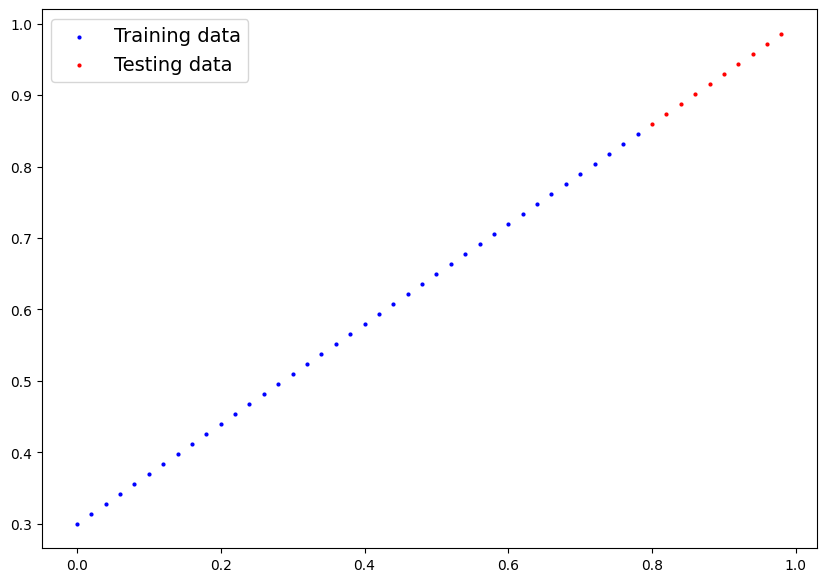

In [18]:
plot()

### Construção do modelo

O que o modelo faz:

* Inicia com valores aleatórios (`weight` e `bias`); e
* Observa os dados de treinamento e ajusta os valores aleatórios para melhor representar os valores ideais (desconhecidos pelo modelo).

Como ele faz isso? Através de dois algoritmos principais:

* Gradient descent
* Backpropagation

In [20]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.weights = nn.Parameter(torch.randn(1, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x: torch.Tensor):
        return self.weights * x + self.bias # y = ax + b